In [1]:
%config IPCompleter.greedy = True
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
%load_ext tensorboard

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import tensorflow as tf
import os
from datetime import datetime
import tensorflow as tf
import sklearn
import random

pd.set_option('mode.chained_assignment', None)
sn.set(rc={'figure.figsize':(9,9)})
sn.set(font_scale=1.4)

# make results reproducible
seed = 0
np.random.seed(seed)
tf.random.set_seed(13)

# Reinforcement Learning

Reinforcement learning (RL) is an area of machine learning concerned with how software agents ought to take actions in an environment in order to maximize the notion of cumulative reward. Reinforcement learning is one of three basic machine learning paradigms, alongside supervised learning and unsupervised learning.

Reinforcement learning differs from supervised learning in not needing labelled input/output pairs be presented, and leanring to act under evaluative feedback (rewards). Instead the focus is on finding a balance between exploration (of uncharted territory) and exploitation (of current knowledge).

The environment is typically stated in the form of a Markov decision process (MDP), because many reinforcement learning algorithms for this context utilize dynamic programming techniques. The main difference between the classical dynamic programming methods and reinforcement learning algorithms (that involve ANNs) is that the latter do not assume knowledge of an exact mathematical model of the MDP and they target large MDPs where exact methods become infeasible.

---

Reinforcement learning is *Agent-oriented learning*, that is learning by interacting with an environment to achieve a goal. Which is learning by trial and error, with only delayed evaluative feedback (reward).

However RL does have some challenges:
* We only have a reward signal as feedback
* Feedback is often delayed
* Time matters, sequential and non-stationary data
* Data received is affected by the agents previous interactions

It has been applied successfully to various problems, including robot control, power control, telecommunications, backgammon, checkers and Go.

## Problem formulation as a Markov Decision Process (MDP)

Often we consider the problem of making a sequence of good decisions. That is in a discrete setting, an agent will make sequence of **actions** $\{a_t\}$, observe a sequence of **observations** $\{o_t\}$ and receive a sequence of **rewards** $\{r_t\}$. We define the **history** at time $t$ to be $h_t = (a_1, o_1, r_1, \dots, a_t, o_t, r_t)$. The agent's function of the history, that is, $a_{t+1} = f(h_t)$, and the problem of sequential decision making can be thought of as defining and computing the function $f$ appropriately.

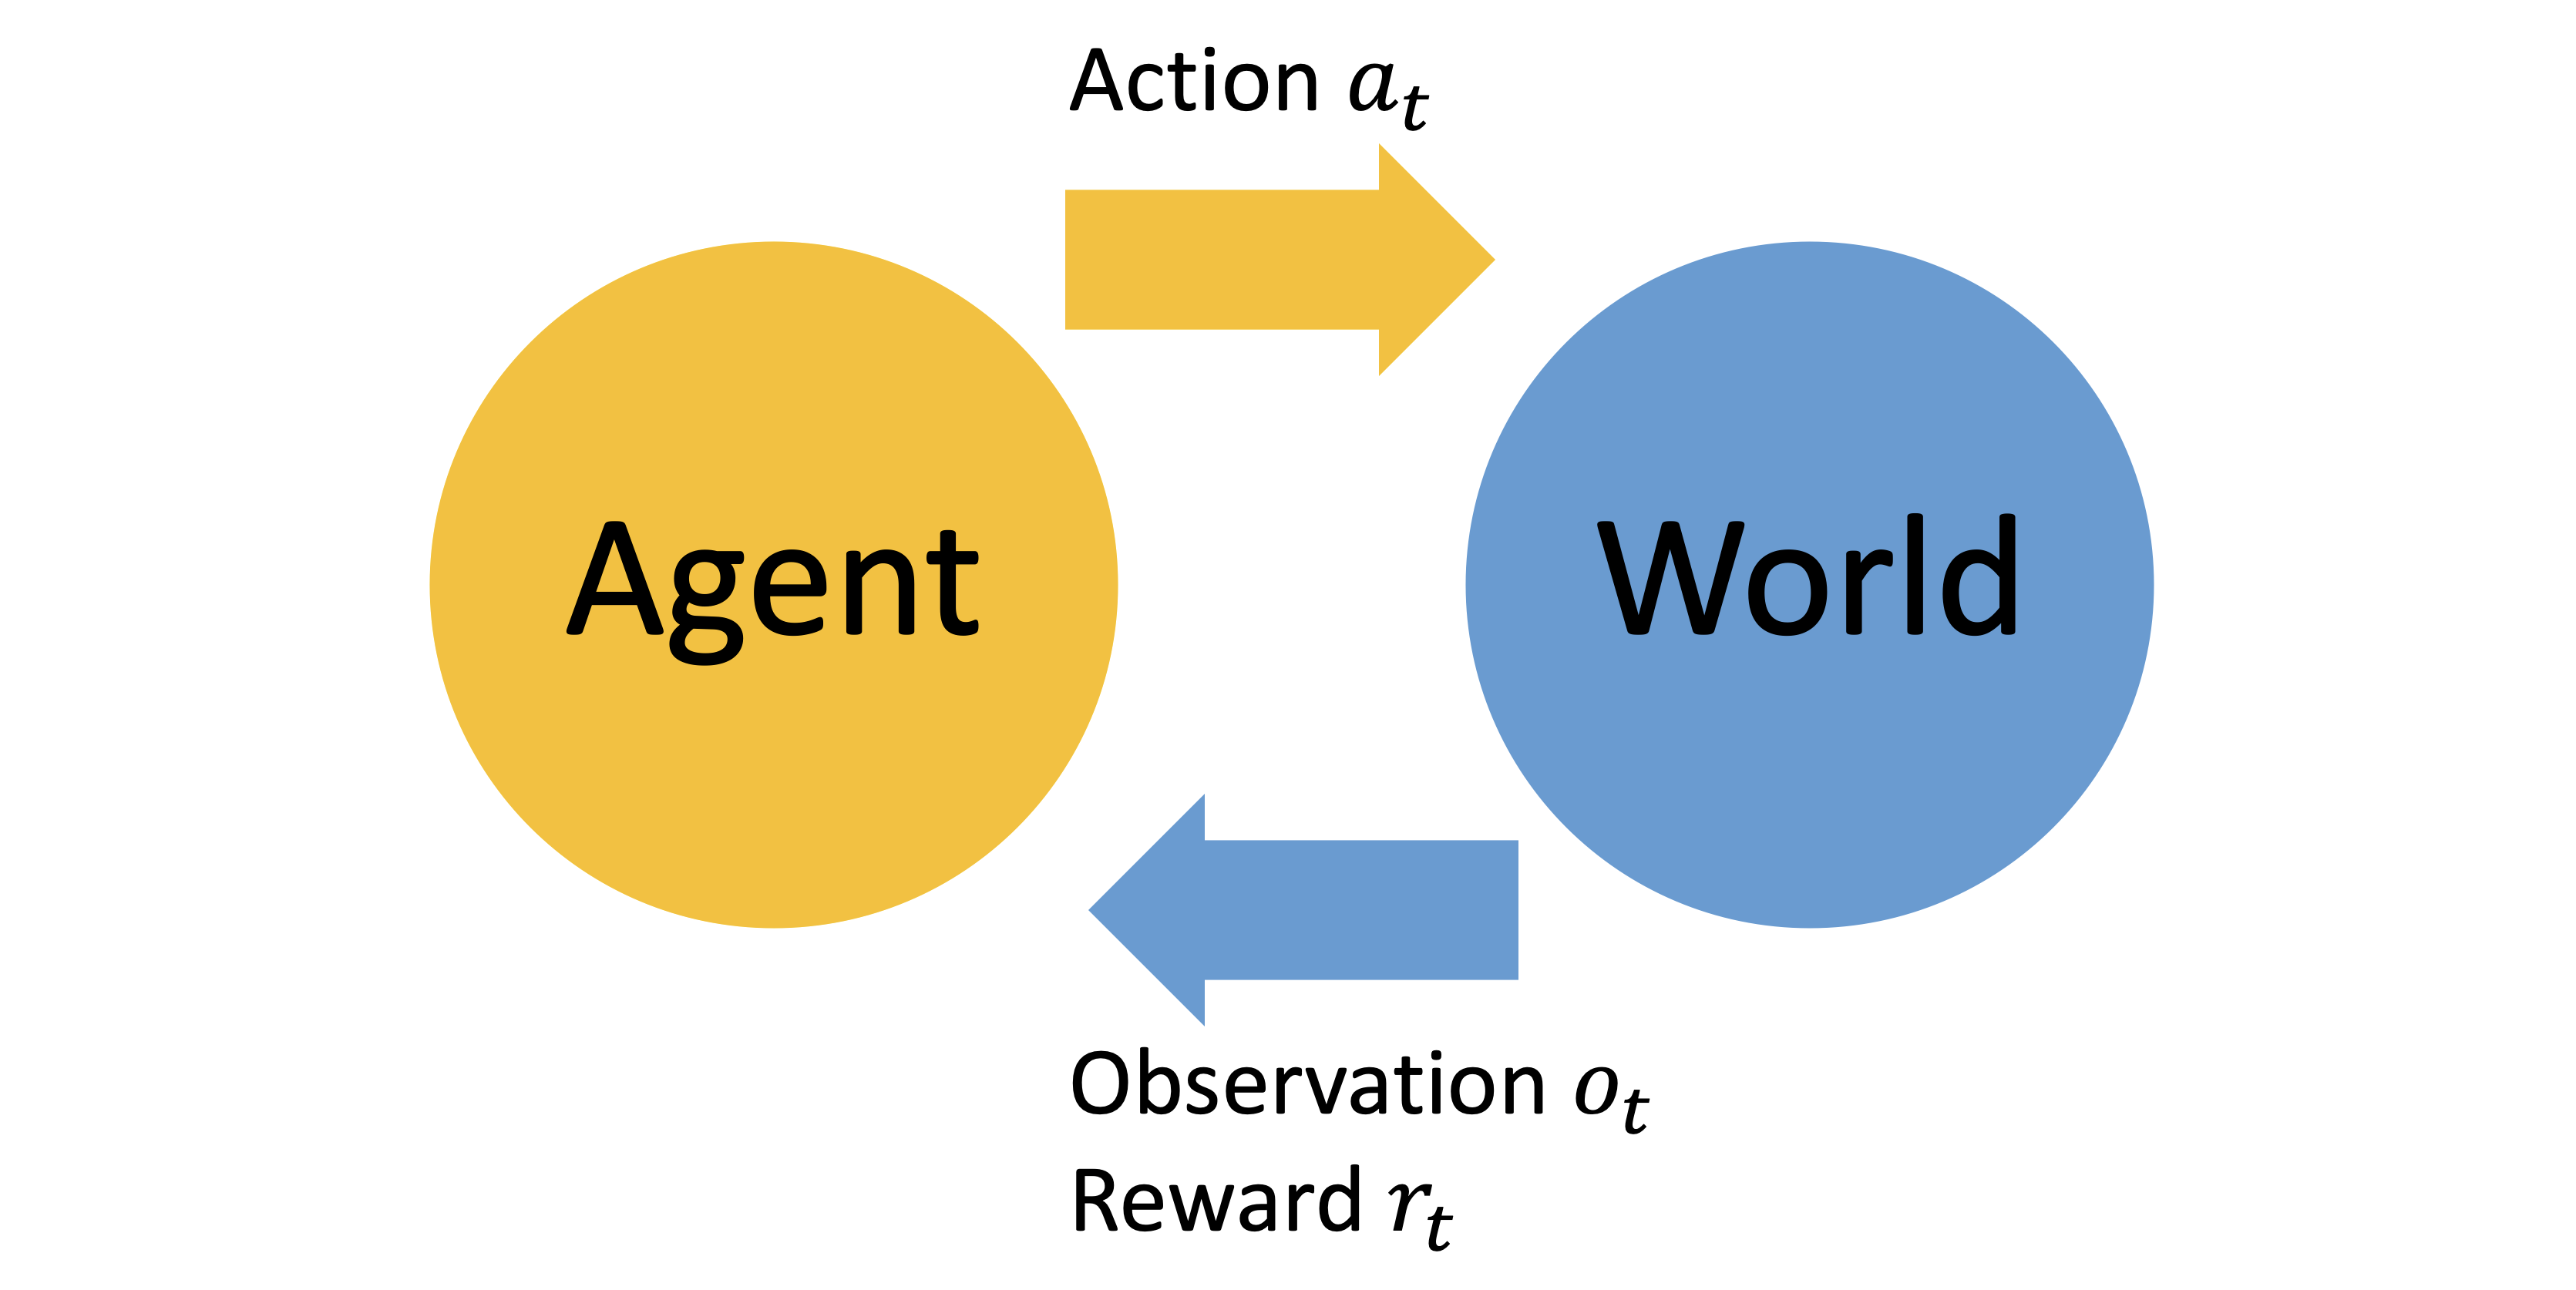


At each step $t$ the agent (as illustrated above) executes action $a_t$, receives observation $o_t$ and receives a scalar reward $r_t$. The environment receives action $a_t$, emits observation $o_{t+1}$ and emits a scalar reward $r_{t+1}$.

Our world may be in a state of possible states ($S$), however the agent observes a sequence of states $\{s_t\}$. We often want to consider the **transition dynamics** of the world $P(s_{t+1}|s_t,a_t,\dots,s_1,a_1)$, a probability distribution over $S$ conditioned on the previous states and actions. In RL, we often assume the **Markov property** that

$$ P(s_{t+1}|s_t,a_t,\dots,s_1,a_1)=P(s_{t+1}|s_t,a_t) $$

We can use the trick to make sure the Markov property holds, by using the history $h_t$ as our state. Usually, we consider the reward $r_t$ to be received on the transition between states, $s_t \xrightarrow{a_t} s_{t+1}$. A reward function is used to predict rewards, $R(s, a, s′) = \mathop{\mathbb{E}}[r_t|s_t = s, a_t = a, s+{t+1} = s′]$. We will often consider the reward function to be of the form $R(s) = \mathop{\mathbb{E}}[r_t|s_t = s]$ or $R(s, a) = \mathop{\mathbb{E}}[r_t|s_t = s, a_t = a]$. A **model** consists of the above transition dynamics and reward function.

The **agent state** is a function of the history, $s^a_t = g(h_t)$, a RL agent typically has an explicit representation of one or more of the following three things, a policy, a value function and optionally a model. A **policy** $\pi$ is a mapping from the agent state to an action, $\pi(s^a_t)\in A$,
or, sometimes it is a stochastic distribution over actions $\pi(a_t|s^a_t)$. When the agent wants to take an action and $\pi$ is stochastic, it picks action $a \in A$ with probability $P(a_t = a) = \pi(a|s^a_t)$. Given a policy $\pi$ and discount factor $\gamma \in [0, 1]$, a **value function** $V^{\pi}$ is an expected sum of discounted rewards (e.g. how good is each state, can also include action),


$$ V^\pi(s) = \mathop{\mathbb{E}_\pi}[r_t + \gamma r_{t+1} + \gamma^2 r_{t+2} + \dots | s_t = s]$$




Where $\mathop{\mathbb{E}_\pi}$ denotes that the expectation is taken over states encountered by following policy $\pi$, and, the discount factor $\gamma$ is used to weigh immediate rewards versus delayed rewards. Lastly, if the agent has a model, we would call it a **model-based** agent, and if it doesn't incorporate a model (agent's representation of the environment), we would call it a **model-free** agent.

For the case where $o_t\neq s_t$ **partially observable**, and it is common in partially observable settings for RL algorithms to maintain a probability distribution over the true world state to define $s^a_t$ , which is known as a **belief state**. However for majority of cases we will consider the fully observable case, where $o_t = s+t$, and will assume that $s^a_t = s_t$.

# Markov Decision Process (MDP)

Here a Markov decision process (MDP) is a discrete time stochastic control process. It provides a mathematical framework for modeling decision making in situations where outcomes are partly random and partly under the control of a decision maker. It is fully defined by the tuple of $(S, A, P, R, \gamma)$:
* $S$ Set of all possible states
* $A$ Set of all possible actions
* $R$ distribution of reward given (state, action) pair
* $P$ transition probability (of the world) i.e. distribution over next state given (state, action) pair
* $\gamma$ discount factor

The core problem of MDPs is to find a **policy** for the agent: a function $\pi$ that specifies the action $\pi(s)$ that the agent will choose when in state $s$. Once a Markov decision process is combined with a policy in this way, this fixes the action for each state and the resulting combination behaves like a Markov chain (since the action chosen in state $s$ is completely determined by $\pi(s)$ and $\Pr(s_{t+1}=s' \mid s_t = s, a_t=a)$ reduces to $\Pr(s_{t+1}=s' \mid s_t = s)$, a Markov transition matrix).

The goal is to choose a policy $\pi$ that will maximize some cumulative function of the random rewards, typically the expected discounted sum over a potentially infinite horizon. Hence the optimal policy $\pi^*$ is given by:

$$\pi^* = \argmax_\pi \mathop{\mathbb{E}}[\sum^{\infty}_{t=0} {\gamma^t R (s_t, a_t, s_{t+1})}] $$

$$ V^*(s) = \argmax_\pi V_{\pi^*}(s)$$

(where we choose $a_t = \pi(s_t)$, i.e. actions given by the policy). And the expectation is taken over $s_{t+1} \sim P_{a_t}(s_t,s_{t+1})$

where $\ \gamma \ $ is the discount factor satisfying $0 \le\ \gamma\ \le\ 1$, which is usually close to 1.

Because of the Markov property, the optimal policy for this particular problem can indeed be written as a function of $s$ only, as assumed above.

The discount-factor motivates the agent to favor taking actions early, rather not postpone them indefinitely.

This optimal policy can be found through a variety of methods, like dynamic programming. Some solutions require knowledge of the state transition function $P$ (**model**) and the reward function $R$. Others can solve for the optimal policy of an MDP using experimentation alone. 

The standard family of algorithms to calculate this optimal policy requires storage for two arrays indexed by state: **value** $V$, which contains real values, and **policy** $\pi$, which contains actions. At the end of the algorithm, $\pi$ will contain the solution and $V(s)$ will contain the discounted sum of the rewards to be earned (on average) by following that solution from state $s$.

The algorithm has two steps, (1) a value update and (2) a policy update, which are repeated in some order for all the states until no further changes take place.  Both recursively update 
a new estimation of the optimal policy and state value using an older estimation of those values.

$$V(s) := \sum_{s'} P_{\pi(s)} (s,s') \left( R_{\pi(s)} (s,s') + \gamma V(s') \right)$$

$$\pi(s) := \operatorname{argmax}_a \left\{ \sum_{s'} P(s' \mid s, a) \left( R(s'\mid s,a) + \gamma V(s') \right) \right\} $$

Their order depends on the variant of the algorithm; one can also do them for all states at once or state by state, and more often to some states than others. As long as no state is permanently excluded from either of the steps, the algorithm will eventually arrive at the correct solution. Some of variants are:

## Value iteration

In value iteration, which is also called backward induction,
the $\pi$ function is not used; instead, the value of $\pi(s)$ is calculated within $V(s)$ whenever it is needed. Substituting the calculation of $\pi(s)$ into the calculation of $V(s)$ gives the combined

$$ V_{i+1}(s) := \max_a \left\{ \sum_{s'} P(s,a,s') \left( R(s,a,s') + \gamma V_i(s') \right) \right\}, $$

where $i$ is the iteration number. Value iteration starts at $i = 0$ and $V_0$ as a guess of the value function. It then iterates, repeatedly computing $V_{i+1}$ for all states $s$, until $V$ converges with the left-hand side equal to the right-hand side (which is the *Bellman equation* for this problem).

## Policy iteration

In policy iteration, step one is performed once, and then step two is repeated until it converges. Then step one is again performed once and so on.

Instead of repeating step two to convergence, it may be formulated and solved as a set of linear equations. These equations are merely obtained by making $s = s'$ in the step two equation. Thus, repeating step two to convergence can be interpreted as solving the linear equations by Relaxation (iterative method).

This variant has the advantage that there is a definite stopping condition: when the array $\pi$ does not change in the course of applying step 1 to all states, the algorithm is completed.

Policy iteration is usually slower than value iteration for a large number of possible states. It takes $O(n^3)$ time to solve for $n$ states, making impratical for large state spaces.


Lets illustrate these with a MDP example, we can first create a MDP class

In [2]:
class BaseMDP:
    """A Markov Decision Process, defined by an initial state, transition model,
    and reward function. We also keep track of a gamma value, for use by
    algorithms. The transition model is represented somewhat differently from
    the text. Instead of P(s' | s, a) being a probability number for each
    state/state/action triplet, we instead have T(s, a) return a
    list of (p, s') pairs. We also keep track of the possible states,
    terminal states, and actions for each state. """

    def __init__(self, init, actlist, terminals, transitions=None, reward=None, states=None, gamma=0.9):
        if not (0 < gamma <= 1):
            raise ValueError("An MDP must have 0 < gamma <= 1")

        # collect states from transitions table if not passed.
        self.states = states or self.get_states_from_transitions(transitions)

        self.init = init

        if isinstance(actlist, list):
            # if actlist is a list, all states have the same actions
            self.actlist = actlist

        elif isinstance(actlist, dict):
            # if actlist is a dict, different actions for each state
            self.actlist = actlist

        self.terminals = terminals
        self.transitions = transitions or {}
        if not self.transitions:
            print("Warning: Transition table is empty.")

        self.gamma = gamma

        self.reward = reward or {s: 0 for s in self.states}

        # self.check_consistency()

    def R(self, state):
        """Return a numeric reward for this state."""

        return self.reward[state]

    def T(self, state, action):
        """Transition model. From a state and an action, return a list
        of (probability, result-state) pairs."""

        if not self.transitions:
            raise ValueError("Transition model is missing")
        else:
            return self.transitions[state][action]

    def actions(self, state):
        """Return a list of actions that can be performed in this state. By default, a
        fixed list of actions, except for terminal states. Override this
        method if you need to specialize by state."""

        if state in self.terminals:
            return [None]
        else:
            return self.actlist

    def get_states_from_transitions(self, transitions):
        if isinstance(transitions, dict):
            s1 = set(transitions.keys())
            s2 = set(tr[1] for actions in transitions.values()
                     for effects in actions.values()
                     for tr in effects)
            return s1.union(s2)
        else:
            print('Could not retrieve states from transitions')
            return None

    def check_consistency(self):

        # check that all states in transitions are valid
        assert set(self.states) == self.get_states_from_transitions(self.transitions)

        # check that init is a valid state
        assert self.init in self.states

        # check reward for each state
        assert set(self.reward.keys()) == set(self.states)

        # check that all terminals are valid states
        assert all(t in self.states for t in self.terminals)

        # check that probability distributions for all actions sum to 1
        for s1, actions in self.transitions.items():
            for a in actions.keys():
                s = 0
                for o in actions[a]:
                    s += o[0]
                assert abs(s - 1) < 0.001

        
class MDP(BaseMDP):
    def __init__(self, init, terminals, transition_matrix, reward = None, gamma=.9):
        # All possible actions.
        actlist = []
        for state in transition_matrix.keys():
            actlist.extend(transition_matrix[state])
        actlist = list(set(actlist))
        BaseMDP.__init__(self, init, actlist, terminals, transition_matrix, reward, gamma=gamma)

    def T(self, state, action):
        if action is None:
            return [(0.0, state)]
        else: 
            return self.transitions[state][action]

Lets implement the simple MDP in the image below. States A, B have actions X, Y available in them. Their probabilities are shown just above the arrows. We start with using BaseMDP as base class for our CustomMDP. Obviously we need to make a few changes to suit our case. We make use of a transition matrix as our transitions are not very simple.

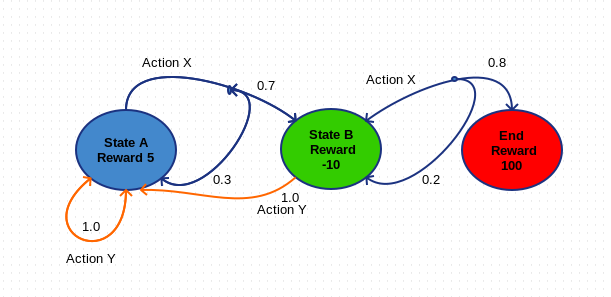

In [23]:
# Transition Matrix as nested dict. State -> Actions in state -> List of (Probability, State) tuples
t = {
    "A": {
            "X": [(0.3, "A"), (0.7, "B")],
            "Y": [(1.0, "A")]
         },
    "B": {
            "X": {(0.8, "End"), (0.2, "B")},
            "Y": {(1.0, "A")}
         },
    "End": {}
}

init = "A"

terminals = ["End"]

rewards = {
    "A": 5,
    "B": -10,
    "End": 100
}

mdp_1 = MDP(init, terminals, t, rewards, gamma=.9)

In [24]:
def value_iteration(mdp, epsilon=0.001):
    """Solving an MDP by value iteration"""
    history = []
    V1 = {s: 0 for s in mdp.states}
    R, T, gamma = mdp.R, mdp.T, mdp.gamma
    while True:
        V = V1.copy()
        history.append(V)
        delta = 0
        for s in mdp.states:
            V1[s] = R(s) + gamma * max(sum(p * V[s1] for (p, s1) in T(s, a))
                                       for a in mdp.actions(s))
            delta = max(delta, abs(V1[s] - V[s]))
        if delta <= epsilon * (1 - gamma) / gamma:
            return V, pd.DataFrame(history)

In [25]:
V, history = value_iteration(mdp_1)
print(V)

{'End': 100.0, 'A': 72.10147625879485, 'B': 75.60975599852492}


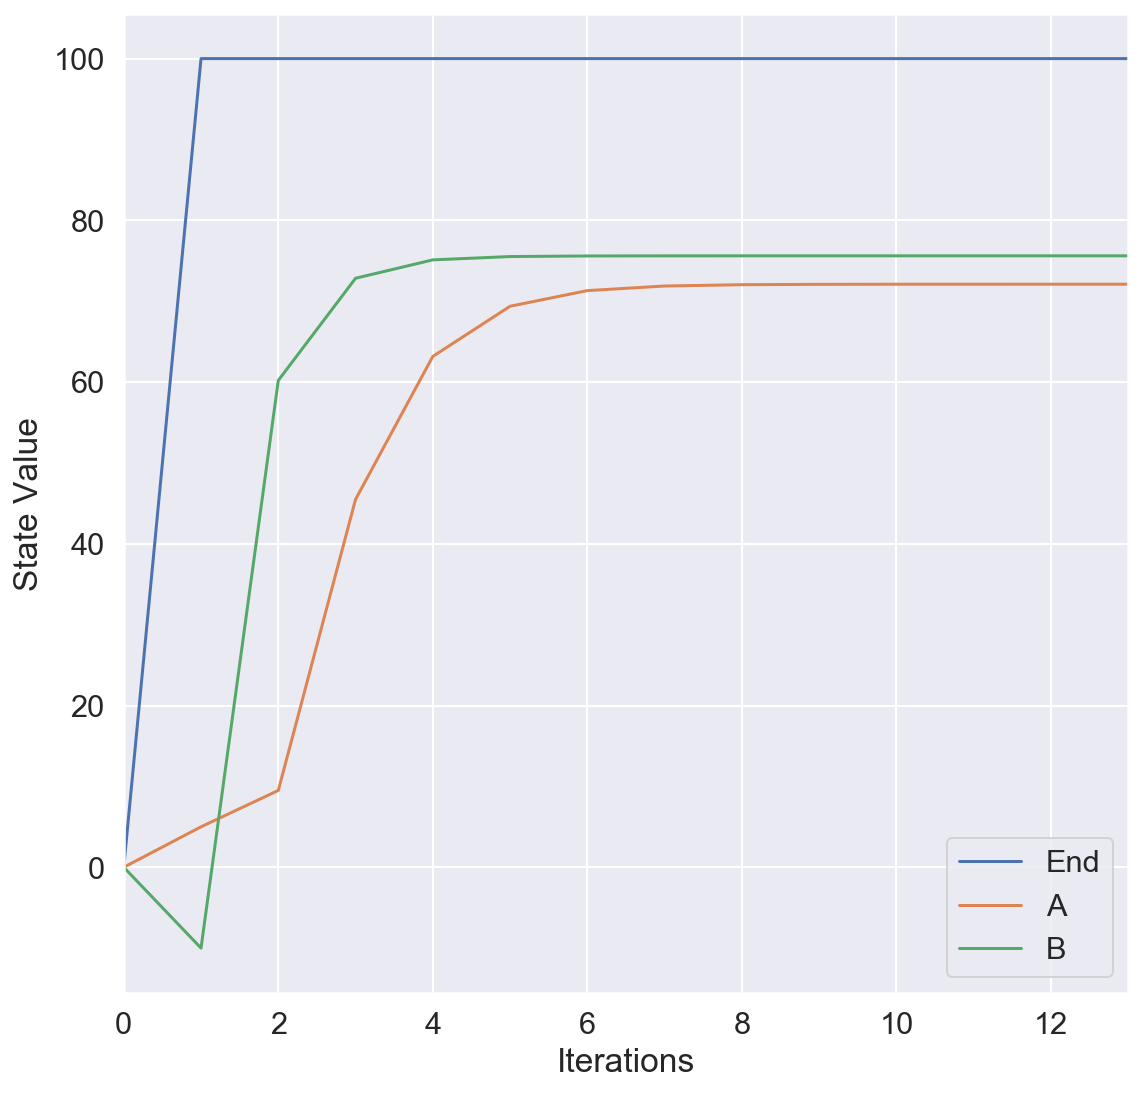

In [26]:
history.plot()
plt.xlabel('Iterations')
plt.ylabel('State Value')
plt.show()

In [27]:
def expected_value(a, s, V, mdp):
    """The expected value of doing a in state s, according to the MDP and V."""

    return sum(p * V[s1] for (p, s1) in mdp.T(s, a))

def policy_evaluation(pi, V, mdp, k=20):
    """Return an updated value mapping V from each state in the MDP to its
    value, using an approximation (modified policy iteration)."""

    R, T, gamma = mdp.R, mdp.T, mdp.gamma
    for i in range(k):
        for s in mdp.states:
            V[s] = R(s) + gamma * sum(p * V[s1] for (p, s1) in T(s, pi[s]))
    return V

def policy_iteration(mdp):
    """Solve an MDP by policy iteration"""

    history = []
    V = {s: 0 for s in mdp.states}
    pi = {s: random.choice(mdp.actions(s)) for s in mdp.states}
    while True:
        V = policy_evaluation(pi, V, mdp)
        history.append(V)
        unchanged = True
        for s in mdp.states:
            a = max(mdp.actions(s), key=lambda a: expected_value(a, s, V, mdp))
            if a != pi[s]:
                pi[s] = a
                unchanged = False
        if unchanged:
            return pi, V, pd.DataFrame(history)

In [28]:
pi, V, history = policy_iteration(mdp_1)
print('Value Function: \n', V)
print('\nPolicy: \n', pi)

Value Function: 
 {'End': 100.0, 'A': 72.10157033064846, 'B': 75.60975609756098}

Policy: 
 {'End': None, 'A': 'X', 'B': 'X'}
